In [1]:
import pandas as pd
import numpy as np
import collections as c
from sklearn.utils import shuffle
from itertools import cycle
from scipy import interp
import csv

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set(style="whitegrid", palette="deep")
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, validation_curve, cross_val_score, cross_val_predict

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score

In [2]:
reg_season = pd.read_csv('data/RegularSeasonDetailedResults.csv')
seasons = pd.read_csv('data/Seasons.csv', index_col = 'Season')
teams = pd.read_csv('data/Teams.csv')#, index_col = 'Team_Id')
tourney = pd.read_csv('data/TourneyDetailedResults.csv')
seeds = pd.read_csv('data/TourneySeeds.csv')
slots = pd.read_csv('data/TourneySlots.csv')
submission = pd.read_csv('data/SampleSubmission2016.csv')

In [3]:
stats = pd.read_csv('data/stats_df.csv')
cols = ['school', 'season', 'sos', 'srs']

team_stats = stats[cols]

In [4]:
def make_id(row):
    return str(row['Season']) + '_' + str(row['Wteam']) + '_' + str(row['Lteam'])

In [5]:
reg_season['game_id'] = None
reg_season['game_id'] = reg_season.apply(lambda row: make_id(row),axis=1)

In [6]:
season_df = reg_season.copy()

In [7]:
#rename columns, winning team becomes team A, losing team becomes team B
col_names = ['season', 'daynum', 'team_A', 'teamA_score', 'team_B', 'teamB_score', 'teamA_loc', 'num_OTs', 
               'teamA_fgm', 'teamA_fga', 'teamA_3ptm', 'teamA_3pta', 'teamA_ftm', 'teamA_fta', 'teamA_offreb',
               'teamA_defreb', 'teamA_asts', 'teamA_turn_ovs', 'teamA_stls', 'teamA_blks', 'teamA_fouls', 
               'teamB_fgm', 'teamB_fga', 'teamB_3ptm', 'teamB_3pta', 'teamB_ftm', 'teamB_fta', 'teamB_offreb',
               'teamB_defreb', 'teamB_asts', 'teamB_turn_ovs', 'teamB_stls', 'teamB_blks', 'teamB_fouls', 'game_id']

season_df.columns = col_names

In [8]:
#shuffle data set to randomize seasons and games
season_df = shuffle(season_df)

In [9]:
season_df.shape

(76636, 35)

In [10]:
#split data set in half, in order to set half of games to wins and half to losses
season_df_1 = season_df[:int((season_df.shape[0]/2))]
season_df_2 = season_df[int((season_df.shape[0]/2)):]

In [11]:
#rename columns of second data frame 
season_df_2.rename(columns={'team_A': 'team_B', 'teamA_score': 'teamB_score', 'team_B': 'team_A',
                             'teamB_score': 'teamA_score', 'teamA_loc': 'teamB_loc', 'teamA_fgm': 'teamB_fgm',
                             'teamA_fga': 'teamB_fga', 'teamA_3ptm': 'teamB_3ptm', 'teamA_3pta': 'teamB_3pta',
                             'teamA_ftm': 'teamB_ftm', 'teamA_fta': 'teamB_fta', 'teamA_offreb': 'teamB_offreb',
                             'teamA_defreb': 'teamB_defreb', 'teamA_asts': 'teamB_asts', 
                             'teamA_turn_ovs': 'teamB_turn_ovs', 'teamA_stls': 'teamB_stls', 'teamA_blks': 'teamB_blks',
                             'teamA_fouls': 'teamB_fouls', 'teamB_fgm': 'teamA_fgm',
                             'teamB_fga': 'teamA_fga', 'teamB_3ptm': 'teamA_3ptm', 'teamB_3pta': 'teamA_3pta',
                             'teamB_ftm': 'teamA_ftm', 'teamB_fta': 'teamA_fta', 'teamB_offreb': 'teamA_offreb',
                             'teamB_defreb': 'teamA_defreb', 'teamB_asts': 'teamA_asts', 
                             'teamB_turn_ovs': 'teamA_turn_ovs', 'teamB_stls': 'teamA_stls', 'teamB_blks': 'teamA_blks',
                             'teamB_fouls': 'teamA_fouls'}, inplace=True)

In [12]:
season_df_1['teamA_win'] = 1
season_df_2['teamA_win'] = 0

In [13]:
season_new_df = pd.concat((season_df_1, season_df_2))
season_new_df = shuffle(season_new_df)

In [14]:
season_new_df['teamA_3ptper'] = season_new_df['teamA_3ptm'] / season_new_df['teamA_3pta']
season_new_df['teamA_fgper'] = season_new_df['teamA_fgm'] / season_new_df['teamA_fga']
season_new_df['teamA_ftper'] = season_new_df['teamA_ftm'] / season_new_df['teamA_fta']

season_new_df['teamB_3ptper'] = season_new_df['teamB_3ptm'] / season_new_df['teamB_3pta']
season_new_df['teamB_fgper'] = season_new_df['teamB_fgm'] / season_new_df['teamB_fga']
season_new_df['teamB_ftper'] = season_new_df['teamB_ftm'] / season_new_df['teamB_fta']

In [15]:
season_new_df['3ptper_diff'] = season_new_df['teamA_3ptper'] - season_new_df['teamB_3ptper']
season_new_df['fgper_diff'] = season_new_df['teamA_fgper'] - season_new_df['teamB_fgper']
season_new_df['ftper_diff'] = season_new_df['teamA_ftper'] - season_new_df['teamB_ftper']

season_new_df['asts_diff'] = season_new_df['teamA_asts'] - season_new_df['teamB_asts']
season_new_df['stls_diff'] = season_new_df['teamA_stls'] - season_new_df['teamB_stls']
season_new_df['blks_diff'] = season_new_df['teamA_blks'] - season_new_df['teamB_blks']

season_new_df['turn_ovs_diff'] = season_new_df['teamA_turn_ovs'] - season_new_df['teamB_turn_ovs']
season_new_df['offreb_diff'] = season_new_df['teamA_offreb'] - season_new_df['teamB_offreb']
season_new_df['defreb_diff'] = season_new_df['teamA_defreb'] - season_new_df['teamB_defreb']
season_new_df['fouls_diff'] = season_new_df['teamA_fouls'] - season_new_df['teamB_fouls']

In [16]:
#combine team_stats with teams data frame
team_stats_df = pd.merge(left=team_stats, right=teams, left_on='school', right_on='Team_Name')

In [17]:
#bring in sos and srs data for team A
season_new_df = pd.merge(left=season_new_df, right=team_stats_df[['season', 'Team_Id', 'sos', 'srs']], 
                         left_on=['season', 'team_A'], right_on=['season', 'Team_Id'], how='outer')

season_new_df = season_new_df.drop(['Team_Id'], axis=1)
season_new_df.rename(columns={'sos': 'teamA_sos', 'srs': 'teamA_srs'}, inplace=True)

In [18]:
#bring in sos and srs data for team B
season_new_df = pd.merge(left=season_new_df, right=team_stats_df[['season', 'Team_Id', 'sos', 'srs']], 
                         left_on=['season', 'team_B'], right_on=['season', 'Team_Id'], how='outer')

season_new_df = season_new_df.drop(['Team_Id'], axis=1)
season_new_df.rename(columns={'sos': 'teamB_sos', 'srs': 'teamB_srs'}, inplace=True)

In [21]:
season_new_df = season_new_df.replace(np.nan, 0)

In [23]:
season_new_df['srs_diff'] = season_new_df['teamA_srs'] - season_new_df['teamB_srs']
season_new_df['sos_diff'] = season_new_df['teamA_sos'] - season_new_df['teamB_sos']

In [24]:
final_cols = ['team_A', 'team_B', 'daynum', 'season', 'game_id', '3ptper_diff', 'fgper_diff',
                    'ftper_diff', 'asts_diff', 'stls_diff', 'blks_diff', 'turn_ovs_diff', 'offreb_diff',
                    'defreb_diff', 'fouls_diff', 'teamA_win', 'sos_diff', 'srs_diff']

final_df = season_new_df[final_cols]

In [25]:
#final_df = final_df.dropna()
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78424 entries, 0 to 78423
Data columns (total 18 columns):
team_A           78424 non-null float64
team_B           78424 non-null float64
daynum           78424 non-null float64
season           78424 non-null int64
game_id          78424 non-null object
3ptper_diff      78424 non-null float64
fgper_diff       78424 non-null float64
ftper_diff       78424 non-null float64
asts_diff        78424 non-null float64
stls_diff        78424 non-null float64
blks_diff        78424 non-null float64
turn_ovs_diff    78424 non-null float64
offreb_diff      78424 non-null float64
defreb_diff      78424 non-null float64
fouls_diff       78424 non-null float64
teamA_win        78424 non-null float64
sos_diff         78424 non-null float64
srs_diff         78424 non-null float64
dtypes: float64(16), int64(1), object(1)
memory usage: 11.4+ MB


In [31]:
def createTrainingSet(df, year):
    df_train = df[df['season'] != year] #remove one year to test on later
    feat_cols = ['3ptper_diff', 'fgper_diff', 'ftper_diff', 'asts_diff',
                 'blks_diff', 'turn_ovs_diff', 'offreb_diff', 'defreb_diff', 'fouls_diff',
                 'sos_diff', 'srs_diff']
    
    X_train = df_train[feat_cols]
    y_train = df_train['teamA_win']

    return X_train, y_train

In [32]:
def createTestSet(df, year):
    df_test = df[df['season'] == year]
    feat_cols = ['3ptper_diff', 'fgper_diff', 'ftper_diff', 'asts_diff',
                 'blks_diff', 'turn_ovs_diff', 'offreb_diff', 'defreb_diff', 'fouls_diff',
                 'sos_diff', 'srs_diff']
    
    X_test = df_test[feat_cols]
    y_test = df_test['teamA_win']

    return X_test, y_test

In [33]:
year = 2016  #season to predict
X_train, y_train = createTrainingSet(final_df, year)
X_test, y_test = createTestSet(final_df, year)

In [56]:
feat_cols = ['3ptper_diff', 'fgper_diff', 'ftper_diff', 'asts_diff',
             'blks_diff', 'turn_ovs_diff', 'offreb_diff', 'defreb_diff', 'fouls_diff',
             'sos_diff', 'srs_diff']

X = final_df[feat_cols]
y = final_df['teamA_win']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

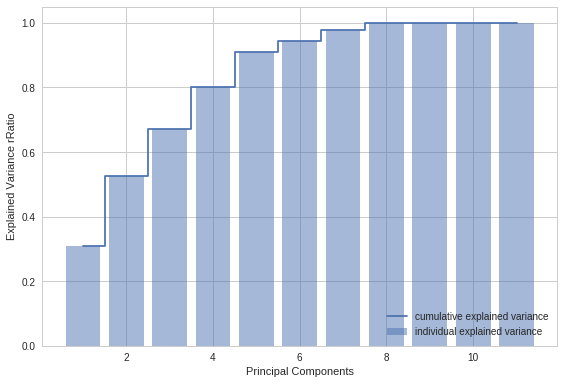

In [35]:
pca = PCA()

pca.fit(X_train)
exp_var = pca.explained_variance_ratio_
exp_var_sum = np.cumsum(exp_var)

#plot explained variance ratio
plt.bar(range(1, len(exp_var) + 1), exp_var_sum, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, len(exp_var) + 1), exp_var_sum, where='mid', label='cumulative explained variance')
plt.ylabel('Explained Variance rRatio')
plt.xlabel('Principal Components')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

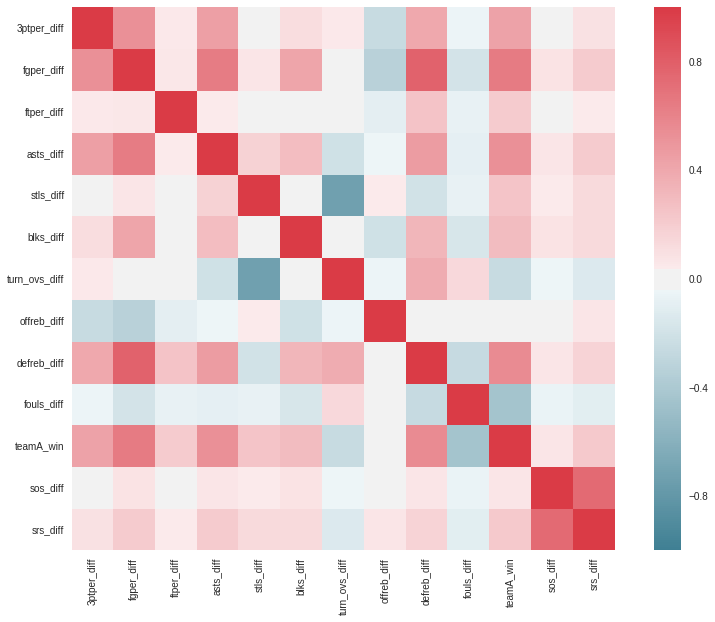

In [36]:
import seaborn as sns

cols = ['3ptper_diff', 'fgper_diff', 'ftper_diff', 'asts_diff', 'stls_diff', 'blks_diff', 
                 'turn_ovs_diff', 'offreb_diff', 'defreb_diff', 'fouls_diff', 'teamA_win', 'sos_diff', 'srs_diff']

f, ax = plt.subplots(figsize=(14, 10))
corr = final_df[cols].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.tight_layout
plt.show()

In [37]:
corr

,3ptper_diff,fgper_diff,ftper_diff,asts_diff,stls_diff,blks_diff,turn_ovs_diff,offreb_diff,defreb_diff,fouls_diff,teamA_win,sos_diff,srs_diff
3ptper_diff,1.000000,0.526716,0.050065,0.449665,-0.001337,0.114391,0.049808,-0.250414,0.405398,-0.054102,0.432002,0.020804,0.088862
fgper_diff,0.526716,1.000000,0.059174,0.637700,0.063789,0.419897,0.027448,-0.330284,0.774286,-0.192491,0.647773,0.082056,0.203164
ftper_diff,0.050065,0.059174,1.000000,0.046592,0.019132,0.031894,-0.012501,-0.100289,0.256864,-0.075636,0.206793,0.004218,0.043190
asts_diff,0.449665,0.637700,0.046592,1.000000,0.178171,0.287356,-0.205867,-0.044200,0.461865,-0.090022,0.529387,0.069653,0.208007
stls_diff,-0.001337,0.063789,0.019132,0.178171,1.000000,0.031596,-0.727876,0.043418,-0.197730,-0.071818,0.248175,0.040187,0.131463
blks_diff,0.114391,0.419897,0.031894,0.287356,0.031596,1.000000,0.002921,-0.203251,0.328097,-0.168497,0.290561,0.078928,0.132503
turn_ovs_diff,0.049808,0.027448,-0.012501,-0.205867,-0.727876,0.002921,1.000000,-0.048363,0.379123,0.139969,-0.250811,-0.046818,-0.138480
offreb_diff,-0.250414,-0.330284,-0.100289,-0.044200,0.043418,-0.203251,-0.048363,1.000000,0.017701,-0.035788,-0.037258,0.027851,0.069964
defreb_diff,0.405398,0.774286,0.256864,0.461865,-0.197730,0.328097,0.379123,0.017701,1.000000,-0.261984,0.556972,0.069421,0.166926
fouls_diff,-0.054102,-0.192491,-0.075636,-0.090022,-0.071818,-0.168497,0.139969,-0.035788,-0.261984,1.000000,-0.438799,-0.056472,-0.109184


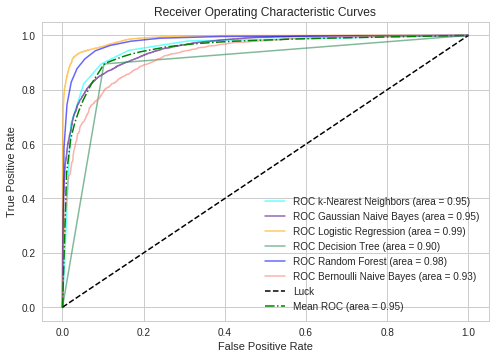

In [57]:
cv = StratifiedKFold(n_splits=10)
models = {
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Bernoulli Naive Bayes': BernoulliNB()
}

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'orange', 'seagreen', 'blue', 'salmon', 'darkorange'])
lw=1.5  #line width
i = 0
for (name, model), color in zip(models.items(), colors):
    probas_ = model.fit(X_train, y_train).predict_proba(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color, alpha=0.6,
             label='ROC %s (area = %0.2f)' % (name, roc_auc))

    i += 1
        
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= i
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='-.',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.legend(loc="lower right")

plt.tight_layout
#plt.savefig('figures/ROC.png', bbox_inches='tight', dpi=300)

plt.show()

In [41]:
def prec_recal_score(model, f, l):
    cross_val_score(model, f, l, cv=10, scoring = 'accuracy')
    y_train_pred = cross_val_predict(model, f, l, cv=5)
    prec_score = precision_score(l, y_train_pred)
    recal_score = recall_score(l, y_train_pred)    
    
    cm = confusion_matrix(l, y_train_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
        
    print('Model: ', model)
    print('Precision Score: ', prec_score)
    print('Recall Score', recal_score)
    print('Specificity Score: ', TNR, '\n')
    print(classification_report(l, y_train_pred))
    print(confusion_matrix(l, y_train_pred))

In [58]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

train_acc = lr.score(X_train, y_train)
test_acc = lr.score(X_test, y_test)

print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)

Train accuracy:  0.944472780441
Test accuracy:  0.945985922677


In [43]:
cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy')
print(np.mean(cv_scores))

0.937909132429


In [44]:
prec_recal_score(lr, X_train, y_train)

Model:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Precision Score:  0.935715689302
Recall Score 0.936872874448
Specificity Score:  0.938894225638 

             precision    recall  f1-score   support

        0.0       0.94      0.94      0.94     37476
        1.0       0.94      0.94      0.94     35579

avg / total       0.94      0.94      0.94     73055

[[35186  2290]
 [ 2246 33333]]


In [45]:
nb = GaussianNB()
nb.fit(X_train, y_train)

train_acc = nb.score(X_train, y_train)
test_acc = nb.score(X_test, y_test)

print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)

Train accuracy:  0.879241667237
Test accuracy:  0.881914695474


In [46]:
prec_recal_score(nb, X_train, y_train)

Model:  GaussianNB(priors=None)
Precision Score:  0.871565013405
Recall Score 0.877174737907
Specificity Score:  0.877281460134 

             precision    recall  f1-score   support

        0.0       0.88      0.88      0.88     37476
        1.0       0.87      0.88      0.87     35579

avg / total       0.88      0.88      0.88     73055

[[32877  4599]
 [ 4370 31209]]


In [47]:
dtc = DecisionTreeClassifier(random_state = 42)

dtc.fit(X_train, y_train)

train_acc = dtc.score(X_train, y_train)
test_acc = dtc.score(X_test, y_test)

print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)

Train accuracy:  1.0
Test accuracy:  0.894952505122


In [48]:
prec_recal_score(dtc, X_train, y_train)

Model:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
Precision Score:  0.855267396907
Recall Score 0.895387728716
Specificity Score:  0.856147934678 

             precision    recall  f1-score   support

        0.0       0.90      0.86      0.88     37476
        1.0       0.86      0.90      0.87     35579

avg / total       0.88      0.88      0.88     73055

[[32085  5391]
 [ 3722 31857]]


In [49]:
pd.DataFrame({'feature': X_train.columns, 'importance': dtc.feature_importances_})

,feature,importance
0,3ptper_diff,0.055081
1,fgper_diff,0.496161
2,ftper_diff,0.043509
3,asts_diff,0.033283
4,blks_diff,0.013036
5,turn_ovs_diff,0.105043
6,offreb_diff,0.038830
7,defreb_diff,0.068016
8,fouls_diff,0.121764
9,sos_diff,0.012172


In [50]:
sgd = SGDClassifier()

sgd.fit(X_train, y_train)

train_acc = sgd.score(X_train, y_train)
test_acc = sgd.score(X_test, y_test)

print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)

Train accuracy:  0.880555745671
Test accuracy:  0.888992363569


In [51]:
prec_recal_score(sgd, X_train, y_train)

Model:  SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
Precision Score:  0.89224418243
Recall Score 0.88692768206
Specificity Score:  0.898308250614 

             precision    recall  f1-score   support

        0.0       0.89      0.90      0.90     37476
        1.0       0.89      0.89      0.89     35579

avg / total       0.89      0.89      0.89     73055

[[33665  3811]
 [ 4023 31556]]


In [52]:
prec_recal_score(lr, X_train, y_train)

Model:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Precision Score:  0.935715689302
Recall Score 0.936872874448
Specificity Score:  0.938894225638 

             precision    recall  f1-score   support

        0.0       0.94      0.94      0.94     37476
        1.0       0.94      0.94      0.94     35579

avg / total       0.94      0.94      0.94     73055

[[35186  2290]
 [ 2246 33333]]


In [55]:
accuracy = []
model = lr

for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2)
    results = model.fit(X_train, y_train)
    preds = model.predict(X_test)

    preds[preds < .5] = 0
    preds[preds >= .5] = 1
    accuracy.append(np.mean(preds == y_test))
    #accuracy.append(np.mean(predictions == Y_test))
    print('Finished iteration: ', i)
print('The accuracy is', sum(accuracy)/len(accuracy))

Finished iteration:  0
Finished iteration:  1
Finished iteration:  2
Finished iteration:  3
Finished iteration:  4
The accuracy is 0.936687873946


In [94]:
def getTeam_Name(team_id):
    try:
        name = teams[teams['Team_Id'] == team_id].Team_Name.values[0]
    except:
        name = 'No Team Name'
    return name

In [101]:
def getTeam_ID(team_name):
    try:
        teamid = teams[teams['Team_Name'] == team_name].Team_Id.values[0]
    except:
        teamid = 'No Team Id'
    return teamid

In [207]:
getTeam_Name(1192)

'F Dickinson'

In [413]:
def getSeason_Data(team_id, season_yr):
    data_season = reg_season[(reg_season['Season'] == season_yr)]  #create dataframe for just season in question
    games_won = data_season[data_season['Wteam'] == team_id]   #df of games won by season & team
    games_lost = data_season[data_season['Lteam'] == team_id]   #df of games lost by season & team
    all_games = games_won.append(games_lost)
    
    num_games = len(all_games.index)
    
    team_name = getTeam_Name(team_id)
    test = reg_season[(reg_season['Wteam'] == team_id) & (reg_season['Season'] == season_yr)].head(1)
    
    if (team_name == 'No Team Name' or len(test) == 0):
        season_3ptper = 0    
        season_fgper = 0
        season_ftper = 0
        season_asts_pg = 0
        season_stls_pg = 0
        season_blks_pg = 0
        season_tos_pg = 0
        season_offreb_pg = 0
        season_defreb_pg = 0
        season_pf_pg = 0
    else:
        total_fgm = games_won.Wfgm.sum() + games_lost.Lfgm.sum()
        total_fga = games_won.Wfga.sum() + games_lost.Lfga.sum()
        season_fgper = total_fgm / total_fga

        total_3ptm = games_won.Wfgm3.sum() + games_lost.Lfgm3.sum()
        total_3pta = games_won.Wfga3.sum() + games_lost.Lfga3.sum()
        season_3ptper = total_3ptm / total_3pta

        total_ftm = games_won.Wftm.sum() + games_lost.Lftm.sum()
        total_fta = games_won.Wfta.sum() + games_lost.Lfta.sum()
        season_ftper = total_ftm / total_fta

        total_offreb = games_won.Wor.sum() + games_lost.Lor.sum()
        season_offreb_pg = total_offreb / num_games

        total_defreb = games_won.Wdr.sum() + games_lost.Ldr.sum()
        season_defreb_pg = total_defreb / num_games

        total_asts = games_won.Wast.sum() + games_lost.Last.sum()
        season_asts_pg = total_asts / num_games

        total_tos = games_won.Wto.sum() + games_lost.Lto.sum()
        season_tos_pg = total_tos / num_games

        total_blks = games_won.Wblk.sum() + games_lost.Lblk.sum()
        season_blks_pg = total_blks / num_games

        total_stls = games_won.Wstl.sum() + games_lost.Lstl.sum()
        season_stls_pg = total_stls / num_games

        total_pfs = games_won.Wpf.sum() + games_lost.Lpf.sum()
        season_pf_pg = total_pfs / num_games
    
    return [season_3ptper, season_fgper, season_ftper, season_asts_pg, #season_stls_pg,
            season_blks_pg, season_tos_pg, season_offreb_pg, season_defreb_pg, season_pf_pg]
    

In [112]:
getTeam_ID('North Carolina')

1314

In [119]:
team = 'North Carolina'
getSeason_Data(getTeam_ID(team), 2012)

[0.33925049309664695,
 0.46070460704607047,
 0.6820877817319099,
 17.441176470588236,
 6.823529411764706,
 5.588235294117647,
 11.764705882352942,
 15.676470588235293,
 29.38235294117647,
 14.794117647058824]

In [111]:
def Team_Compare(team_A, team_B, year):
    team_1 = getSeason_Data(team_A, year)
    team_2 = getSeason_Data(team_B, year)
    diff = [a - b for a, b in zip(team_1, team_2)]
    return diff

In [412]:
Team_Compare(1455, 1462, 2016)

[-0.03309773620012402,
 -0.0191433031209845,
 -0.015010762433442792,
 -2.05241935483871,
 -0.05443548387096797,
 0.5181451612903225,
 -2.911290322580646,
 -1.449596774193548,
 -2.066532258064516,
 0.03830645161290391]

In [107]:
team_list = teams['Team_Name'].tolist()

In [108]:
def MakeSeason_Dict(year):
    season_dict = c.defaultdict(list)
    for team in team_list:
        team_id = teams[teams['Team_Name'] == team].values[0][0]
        team_vector = Season_Data(team_id, year)
        season_dict[team_id] = team_vector
    return season_dict

In [390]:
models = {
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Bernoulli Naive Bayes': BernoulliNB()
}
def predictOutcomes(team1, team2, year, X, y):
    diff = Team_Compare(getTeam_ID(team1), getTeam_ID(team2), year)
    outcomes = []
    for k, v in models.items():
        v.fit(X, y)
        outcomes.append((k + ': ' + 'Probability that ' + team1_name + ' beats ' + team2_name + ': ', v.predict_proba(diff)[0,0]))
        #outcomes.append(outcome)
    return outcomes
    #return model.predict(diff)

In [394]:
def predictOutcome(team1, team2, year, X, y):
    diff = Team_Compare(team1, team2, year)
    lr.fit(X, y)
    return lr.predict_proba(diff)

In [351]:
team1_name = 'Villanova'
team2_name = 'Kansas'
#year = 2017

team1_vector = getSeason_Data(getTeam_ID(team1_name), year)
team2_vector = getSeason_Data(getTeam_ID(team2_name), year)

#print('Probability that ' + team1_name + ' wins:', predictOutcome(team1_name, team2_name, year))
predictOutcome(team1_name, team2_name, year, X_train, y_train)

[('k-Nearest Neighbors: Probability that Villanova beats Kansas: ',
  0.80000000000000004),
 ('Gaussian Naive Bayes: Probability that Villanova beats Kansas: ',
  0.46232592791322225),
 ('Logistic Regression: Probability that Villanova beats Kansas: ',
  0.2450757105328305),
 ('Decision Tree: Probability that Villanova beats Kansas: ', 0.0),
 ('Random Forest: Probability that Villanova beats Kansas: ',
  0.40000000000000002),
 ('Bernoulli Naive Bayes: Probability that Villanova beats Kansas: ',
  0.43174711160664542)]

In [387]:
getSeason_Data(1463, 2016)

[0.37124463519313305,
 0.46728354263053534,
 0.6666666666666666,
 15.074074074074074,
 5.592592592592593,
 4.518518518518518,
 13.481481481481481,
 13.481481481481481,
 26.814814814814813,
 17.962962962962962]

In [427]:
submission.tail()

,Id,Pred
2273,2016_1455_1462,0.5
2274,2016_1455_1463,0.5
2275,2016_1458_1462,0.5
2276,2016_1458_1463,0.5
2277,2016_1462_1463,0.5


In [414]:
def predictOutcome(team1, team2, year, X, y):
    diff = Team_Compare(team1, team2, year)
    lr = LogisticRegression()
    lr.fit(X, y)
    return lr.predict_proba(diff)

In [415]:
predictOutcome(1455, 1462, 2016, X_train, y_train)

array([[ 0.5922446,  0.4077554]])

In [444]:
sub = submission.head(10)

In [501]:
def createPrediction():
    game_id = []
    outcome_prob = []
    sub_df = pd.DataFrame()
    
    for index, row in submission.iterrows():
        id_row = row['Id']
        year = int(id_row[0:4])
        team1_id = int(id_row[5:9])
        team2_id = int(id_row[10:14])

        pred = predictOutcome(team1_id, team2_id, year, X_train, y_train)

        game_id.append(id_row)
        outcome_prob.append(pred[0,0])
    sub_dict = dict(zip(game_id, outcome_prob))

    outfile = open('2016_submission.csv', 'w')
    for key, value in sorted(sub_dict.items()):
        outfile.write( str(key) + ', ' + str(value) + '\n')

In [502]:
#createPrediction()